## Heart Attack Prediction

# Dependencies

In [55]:
import os
import pickle

# Data manipulation and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from scipy.stats import pointbiserialr

# Machine learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Data Loading

In [2]:
heart_df = pd.read_csv('datasets\heart.csv')
print(heart_df.head())

   age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0   63    1   3     145   233    1        0       150     0      2.3    0   
1   37    1   2     130   250    0        1       187     0      3.5    0   
2   41    0   1     130   204    0        0       172     0      1.4    2   
3   56    1   1     120   236    0        1       178     0      0.8    2   
4   57    0   0     120   354    0        1       163     1      0.6    2   

   caa  thall  output  
0    0      1       1  
1    0      2       1  
2    0      2       1  
3    0      2       1  
4    0      2       1  


# Data Cleaning and Preprocessing (missing values, duplicates, outliers, anomalies)

In [3]:
# Cramers Function for correlation between categorical and target variable

def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))  
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [4]:
# Checking for missing values
heart_df.isna().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

In [5]:
# Describe the data in terms of count, mean, std, min, max, and IQR
print(heart_df.describe().T)


          count        mean        std    min    25%    50%    75%    max
age       303.0   54.366337   9.082101   29.0   47.5   55.0   61.0   77.0
sex       303.0    0.683168   0.466011    0.0    0.0    1.0    1.0    1.0
cp        303.0    0.966997   1.032052    0.0    0.0    1.0    2.0    3.0
trtbps    303.0  131.623762  17.538143   94.0  120.0  130.0  140.0  200.0
chol      303.0  246.264026  51.830751  126.0  211.0  240.0  274.5  564.0
fbs       303.0    0.148515   0.356198    0.0    0.0    0.0    0.0    1.0
restecg   303.0    0.528053   0.525860    0.0    0.0    1.0    1.0    2.0
thalachh  303.0  149.646865  22.905161   71.0  133.5  153.0  166.0  202.0
exng      303.0    0.326733   0.469794    0.0    0.0    0.0    1.0    1.0
oldpeak   303.0    1.039604   1.161075    0.0    0.0    0.8    1.6    6.2
slp       303.0    1.399340   0.616226    0.0    1.0    1.0    2.0    2.0
caa       303.0    0.729373   1.022606    0.0    0.0    0.0    1.0    4.0
thall     303.0    2.313531   0.612277

In [6]:
# Checking for anomalies
heart_df.nunique()

age          41
sex           2
cp            4
trtbps       49
chol        152
fbs           2
restecg       3
thalachh     91
exng          2
oldpeak      40
slp           3
caa           5
thall         4
output        2
dtype: int64

In [7]:
# Querying the data with invalid inputs or anomalies 
heart_df.query('thall == 0 or caa == 4')

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
48,53,0,2,128,216,0,0,115,0,0.0,2,0,0,1
92,52,1,2,138,223,0,1,169,0,0.0,2,4,2,1
158,58,1,1,125,220,0,1,144,0,0.4,1,4,3,1
163,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1
164,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1
251,43,1,0,132,247,1,0,143,1,0.1,1,4,3,0
281,52,1,0,128,204,1,1,156,1,1.0,1,0,0,0


In [8]:
# Dropping rows with anomalies
heart_df.drop(heart_df.query('thall == 0 or caa == 4').index, axis=0, inplace = True)
heart_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,296.0,54.523649,9.059471,29.0,48.0,56.0,61.00,77.0
sex,296.0,0.679054,0.467631,0.0,0.0,1.0,1.00,1.0
cp,296.0,0.959459,1.034184,0.0,0.0,1.0,2.00,3.0
trtbps,296.0,131.604730,17.726620,94.0,120.0,130.0,140.00,200.0
chol,296.0,247.155405,51.977011,126.0,211.0,242.5,275.25,564.0
fbs,296.0,0.145270,0.352970,0.0,0.0,0.0,0.00,1.0
restecg,296.0,0.523649,0.526692,0.0,0.0,1.0,1.00,2.0
thalachh,296.0,149.560811,22.970792,71.0,133.0,152.5,166.00,202.0
exng,296.0,0.327703,0.470171,0.0,0.0,0.0,1.00,1.0
oldpeak,296.0,1.059122,1.166474,0.0,0.0,0.8,1.65,6.2


In [9]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       296 non-null    int64  
 1   sex       296 non-null    int64  
 2   cp        296 non-null    int64  
 3   trtbps    296 non-null    int64  
 4   chol      296 non-null    int64  
 5   fbs       296 non-null    int64  
 6   restecg   296 non-null    int64  
 7   thalachh  296 non-null    int64  
 8   exng      296 non-null    int64  
 9   oldpeak   296 non-null    float64
 10  slp       296 non-null    int64  
 11  caa       296 non-null    int64  
 12  thall     296 non-null    int64  
 13  output    296 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 34.7 KB


In [10]:
# Shows the rows and columns of our heart_df dataframe  
heart_df.shape

(296, 14)

In [11]:
heart_df.columns

Index(['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh',
       'exng', 'oldpeak', 'slp', 'caa', 'thall', 'output'],
      dtype='object')

In [12]:
# To find out which features should be a numerical/ continuos  
for col in heart_df.columns:
    print(heart_df[col].unique())

[63 37 41 56 57 44 52 54 48 49 64 58 50 66 43 69 59 42 61 40 71 51 65 53
 46 45 39 47 62 34 35 29 55 60 67 68 74 76 70 77 38]
[1 0]
[3 2 1 0]
[145 130 120 140 172 150 110 135 160 105 125 142 155 104 138 108 134 122
 115 118 128 100 124  94 112 102 152 101 132 148 178 129 180 136 126 106
 156 170 146 117 200 165 174 192 144 123 154 114 164]
[233 250 204 236 354 192 294 263 199 168 239 275 266 211 283 219 340 226
 247 234 243 302 212 175 417 197 198 177 273 213 304 232 269 360 308 245
 208 264 321 325 235 257 256 231 141 252 201 222 260 182 303 265 309 186
 203 183 220 209 258 227 261 221 205 240 318 298 564 277 214 248 255 207
 288 160 394 315 246 244 270 195 196 254 126 313 262 215 193 271 268 267
 210 295 306 178 223 242 180 228 149 278 253 342 157 286 229 284 224 206
 167 230 335 276 353 225 330 290 172 305 216 188 282 185 326 274 164 307
 249 341 407 217 174 281 289 322 299 300 293 184 409 259 200 327 237 218
 319 166 311 169 187 176 241 131]
[1 0]
[0 1 2]
[150 187 172 178 163 148 1

<AxesSubplot: >

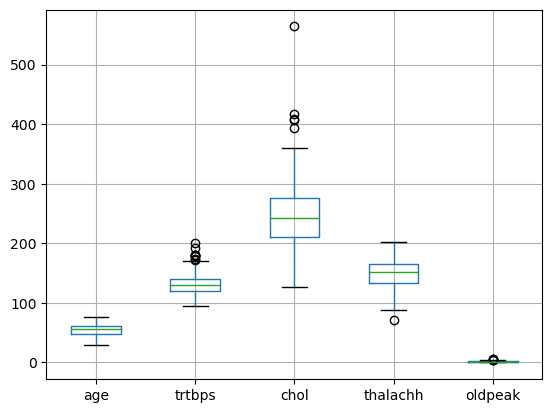

In [13]:
# Checking for outliers
numeric_col = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
heart_df.boxplot(numeric_col)

In [14]:
"""
-Boxplots use quartiles
	-Third Quartile top box
	- Second Quartile medium
	- First Quartile bottom
	- we can use np.linspace(start, stop, step) to calculate quartiles 
- IQR
	-distance between 25th to 75 (meaning the height of the box in a boxplot)
	-from scipy.stats import iqr ---- iqr(msleep['sleep_total']) 
	
- Outliers: 
	- any data < q1 - 1.5 * IQR 
	- any data > q3 + 1.5 * IQR
"""
for x in numeric_col:
    q75, q25 = np.percentile(heart_df.loc[:,x], [75,25])
    intr_qr = q75 - q25

    maximum = q75+(1.5*intr_qr)
    minimum = q25-(1.5*intr_qr)

    heart_df.loc[heart_df[x] < minimum, x] = np.nan
    heart_df.loc[heart_df[x] > maximum, x] = np.nan


In [15]:
heart_df.isnull().sum()

age         0
sex         0
cp          0
trtbps      9
chol        5
fbs         0
restecg     0
thalachh    1
exng        0
oldpeak     5
slp         0
caa         0
thall       0
output      0
dtype: int64

In [16]:
heart_df = heart_df.dropna(axis=0)


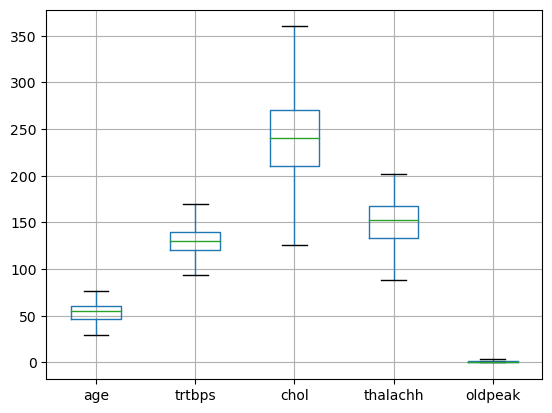

In [17]:
numeric_col = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
heart_df.boxplot(numeric_col)
plt.show()


# Feature Selection

In [18]:
con = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
cat = heart_df.drop(labels=con, axis=1)

In [19]:
for i in cat:
    print(i)
    matrix = pd.crosstab(heart_df[i], heart_df['output']).to_numpy()
    print((cramers_corrected_stat(matrix)))

sex
0.3076872619004317
cp
0.49290184768444817
fbs
0.0
restecg
0.15534742926933376
exng
0.4087031229681863
slp
0.36696811008735214
caa
0.48884823982322084
thall
0.5354307553647626
output
0.9926615194824767


In [20]:
for i in con:
    print(i)
    lr = LogisticRegression()
    lr.fit(np.expand_dims(heart_df[i], axis=1), heart_df['output'])
    print(lr.score(np.expand_dims(heart_df[i], axis=1), heart_df['output']))

age
0.6173285198555957
trtbps
0.5740072202166066
chol
0.5487364620938628
thalachh
0.7003610108303249
oldpeak
0.6895306859205776


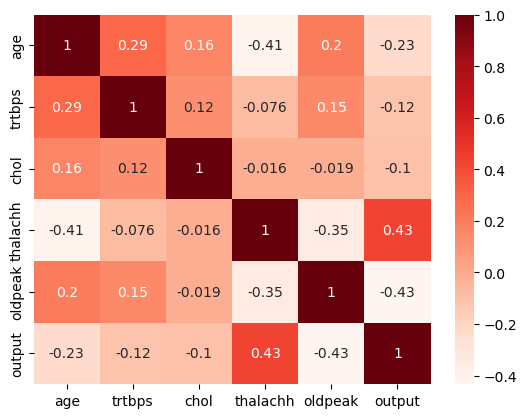

In [21]:
# Finding the corelation coefficient between con data to output

df_con = heart_df.loc[:, ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak', 'output']]
corr= df_con.corr()

df_con.corr()['output'].sort_values()
sns.heatmap(corr, cmap='Reds', annot=True)
plt.show()

# EDA


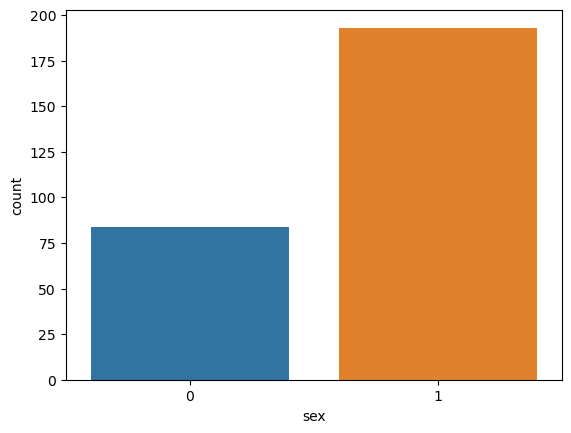

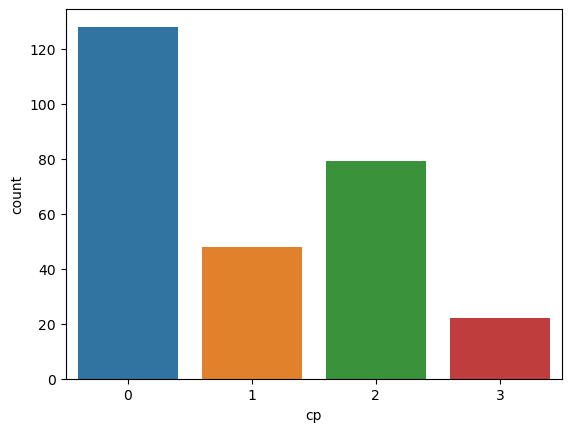

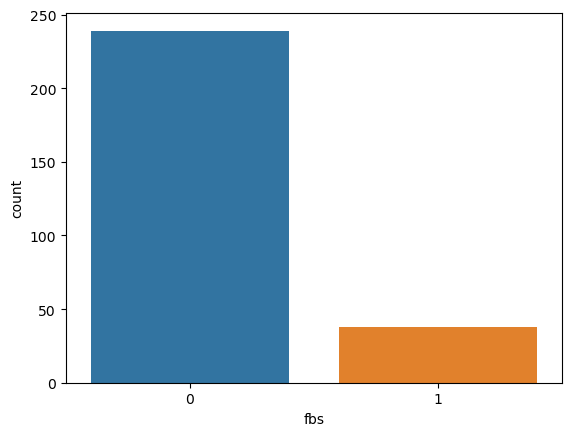

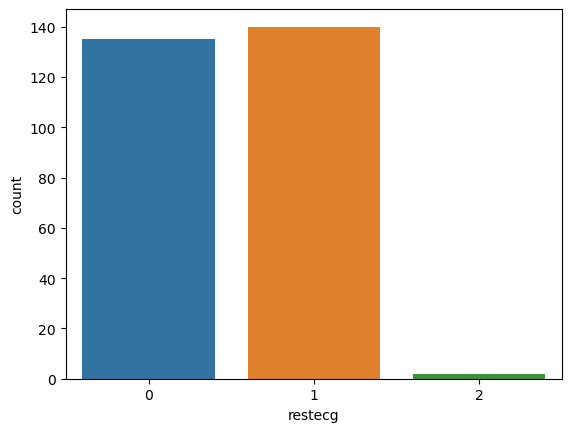

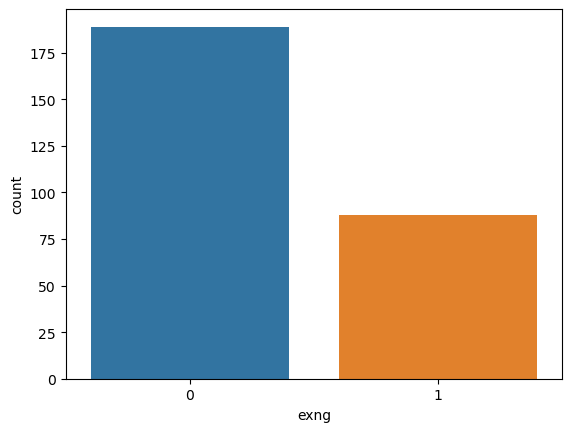

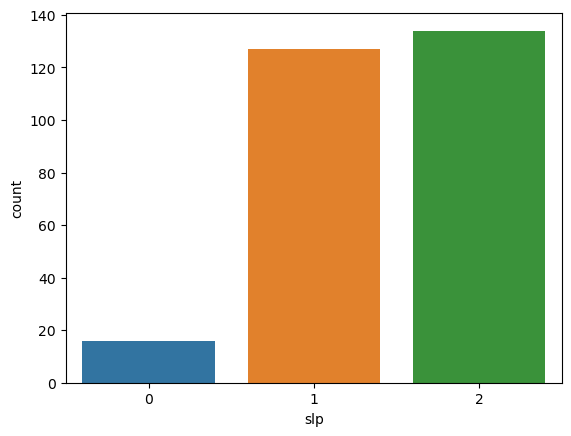

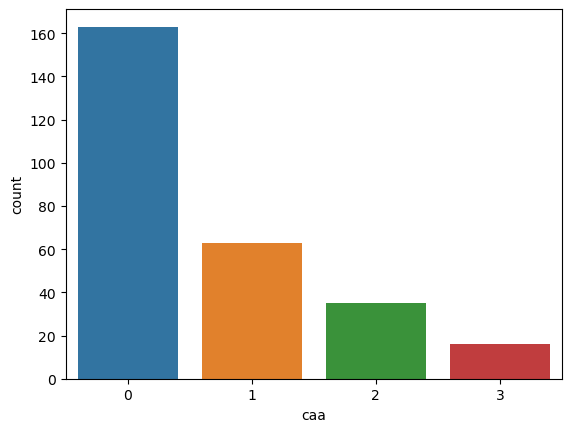

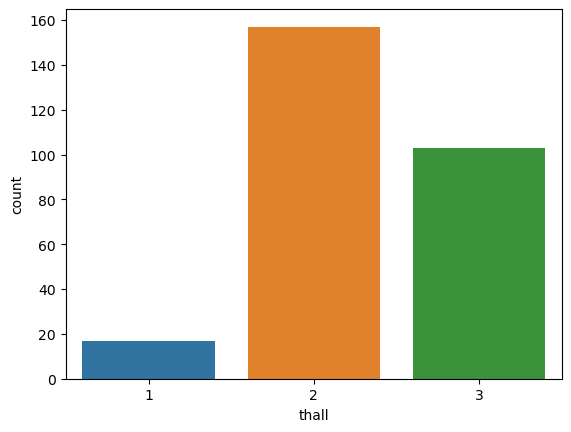

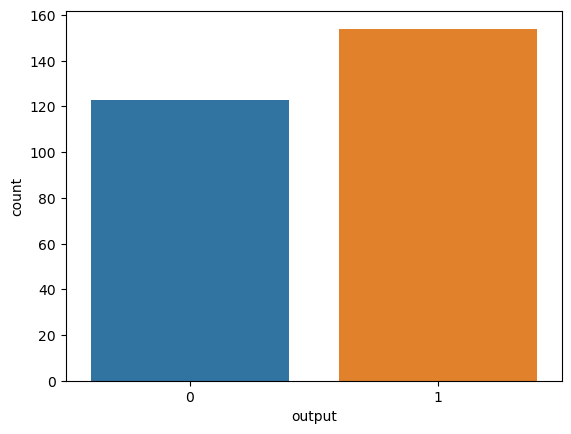

In [22]:
# Plotting categorical data
palettes = ["deep", "muted", "pastel", "bright", "dark"]

for i, x in enumerate(cat):
    sns.color_palette("husl", 8)
    sns.countplot(data=heart_df, x=x)
    plt.xlabel(x)
    plt.show()

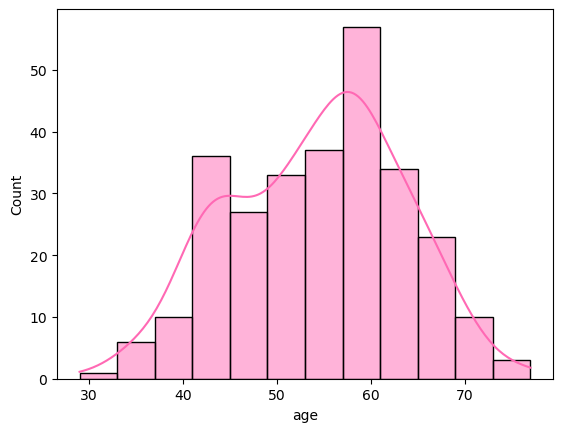

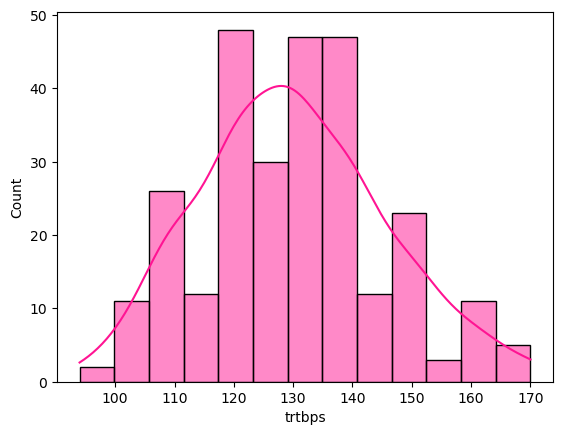

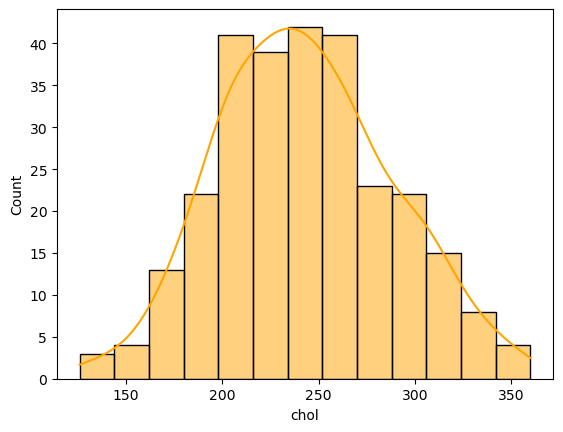

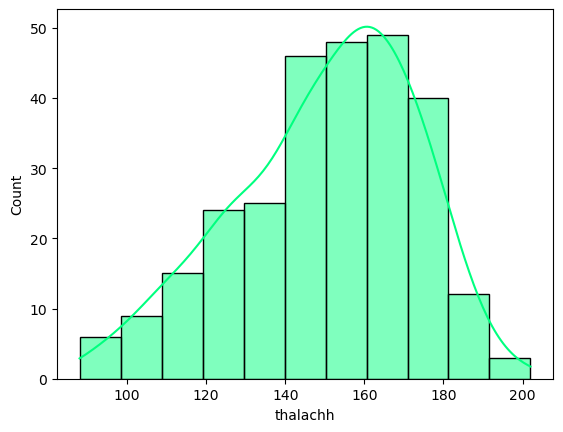

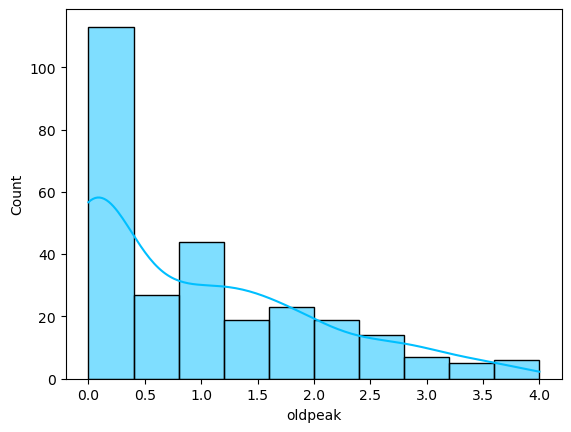

In [23]:
colors = ["#ff69b4", "#ff1493", "#ffa500", "#00ff7f", "#00bfff"]
for i, x in enumerate(con):
    sns.histplot(data=heart_df, x=x, kde=True, color=colors[i])
    plt.xlabel(x)
    plt.show()


In [24]:
print(heart_df.groupby(['sex', 'output']).agg({'output':'count'}).plot(kind='bar'))

AxesSubplot(0.125,0.11;0.775x0.77)


# MODEL SELECTION AND TRAINING

In [25]:
# Creating X_train which is the features without target variable, y_train which is the target variable
X_train = heart_df.drop(labels = "output", axis = 1)
y_train = heart_df["output"]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2 , random_state= 42, stratify=y_train)

In [27]:
# Logistic Regression Pipeling
pipeline_mms_lr = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('logistic_regression', LogisticRegression())
])

pipeline_ss_lr = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('logistic_regression', LogisticRegression())
])

# Random Forest
pipeline_mms_rf = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('random_forest', RandomForestClassifier())
])

pipeline_ss_rf = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('random_forest', RandomForestClassifier())
])

# Gradient Boost
pipeline_mms_gb = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('gradient_boost', GradientBoostingClassifier())
])

pipeline_ss_gb = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('gradient_boost', GradientBoostingClassifier())
])


# SVC
pipeline_mms_svc = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('svc', SVC())
])

pipeline_ss_svc = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('svc', SVC())
])


In [28]:
pipelines = [pipeline_mms_lr, pipeline_ss_lr,
            pipeline_mms_rf, pipeline_ss_rf,
            pipeline_mms_gb, pipeline_ss_gb,
            pipeline_mms_svc, pipeline_ss_svc
            ]

In [29]:
pipe_dict = {}
best_score = 0
# Key for the dictionary
model_name = ['MMS + Logistic Regression', 'SS + Logistic Regression', 
              'MMS + Random Forest', 'SS + Random Forest', 
              'MMS + Gradient Boost', 'SS + Gradient Boost', 
              'MMS + SVC', 'SS + SVC'
              ]

In [30]:
for pipe in pipelines:
    pipe.fit(X_train, y_train)

In [31]:
# Model Evaluation

for i, model in enumerate(pipelines):
    y_pred = model.predict(X_test)
    # key is mode_name, values are accuracy score and f1 score
    pipe_dict[model_name[i]] = [accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted')]

    # To get the best score from each model
    if model.score(X_test, y_test) > best_score:
        best_score = model.score(X_test, y_test)
        best_pipeline = model_name[i]


In [33]:
print('The best model for heart attack prediction is {} with the accuracy score of {}'.format(best_pipeline, best_score))

The best model for heart attack prediction is MMS + Gradient Boost with the accuracy score of 0.8571428571428571


In [34]:
print(pipe_dict)

{'MMS + Logistic Regression': [0.8392857142857143, 0.8363539445628998], 'SS + Logistic Regression': [0.8214285714285714, 0.8190758516845474], 'MMS + Random Forest': [0.8035714285714286, 0.8031260123096857], 'SS + Random Forest': [0.8392857142857143, 0.8378653261631985], 'MMS + Gradient Boost': [0.8571428571428571, 0.8571428571428571], 'SS + Gradient Boost': [0.8571428571428571, 0.8571428571428571], 'MMS + SVC': [0.8392857142857143, 0.8363539445628998], 'SS + SVC': [0.8214285714285714, 0.8190758516845474]}


In [35]:
# Converting pipe into DataFrame    
model_comparison_df = pd.DataFrame.from_dict(pipe_dict).T
model_comparison_df.columns = ['Accuracy_score', 'f1_score']
model_comparison_df.sort_values(['Accuracy_score', 'f1_score'], ascending = False, inplace=True)
model_comparison_df.style.background_gradient(cmap='viridis')

,Accuracy_score,f1_score
MMS + Gradient Boost,0.857143,0.857143
SS + Gradient Boost,0.857143,0.857143
SS + Random Forest,0.839286,0.837865
MMS + Logistic Regression,0.839286,0.836354
MMS + SVC,0.839286,0.836354
SS + Logistic Regression,0.821429,0.819076
SS + SVC,0.821429,0.819076
MMS + Random Forest,0.803571,0.803126


# Hyperparameter Tuning

In [36]:
pipelines_ht = [pipeline_mms_lr, pipeline_ss_lr,
            pipeline_mms_rf, pipeline_ss_rf,
            pipeline_mms_gb, pipeline_ss_gb,
            pipeline_mms_svc, pipeline_ss_svc
            ]

In [37]:
pipe_dict_ht = {}
best_score_ht = 0
# Key for the dictionary
model_name_ht = ['MMS + Logistic Regression', 'SS + Logistic Regression', 
              'MMS + Random Forest', 'SS + Random Forest', 
              'MMS + Gradient Boost', 'SS + Gradient Boost', 
              'MMS + SVC', 'SS + SVC'
              ]

In [38]:
log_param_grid = {'logistic_regression__C': np.logspace(-5, 10, 15)}

rf_param_grid = {'random_forest__n_estimators': [100, 500, 1000],
                 'random_forest__max_depth': [5, 10, 15],
                 'random_forest__min_samples_split': [2, 5, 10]}

gb_param_grid = {'gradient_boost__n_estimators': [100, 500, 1000],
                 'gradient_boost__learning_rate': [0.01, 0.1, 1],
                 'gradient_boost__max_depth': [1, 3, 5]}

svc_param_grid = {'svc__C': [0.1, 1, 10],
                  'svc__kernel': ['linear', 'rbf'],
                  'svc__gamma': [0.01, 0.1, 1]}

log_param_grids = [log_param_grid]*2
rf_param_grids = [rf_param_grid]*2
gb_param_grids = [gb_param_grid]*2
svc_param_grids = [svc_param_grid]*2
param_grids = log_param_grids + rf_param_grids + gb_param_grids + svc_param_grids

In [39]:
best_params = {}
for i, model in enumerate(pipelines_ht):
    cv_ht = GridSearchCV(model, param_grid=param_grids[i])
    cv_ht.fit(X_train, y_train)
    best_params[model_name_ht[i]] = cv_ht.best_params_
    y_pred = cv_ht.predict(X_test)
    pipe_dict_ht[model_name_ht[i]] = [accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted')]
    if cv_ht.best_score_ > best_score_ht:
        best_pipeline_ht = model_name_ht[i]
        best_score_ht = cv_ht.best_score_

In [40]:
print(best_params)

{'MMS + Logistic Regression': {'logistic_regression__C': 0.19306977288832497}, 'SS + Logistic Regression': {'logistic_regression__C': 0.016378937069540647}, 'MMS + Random Forest': {'random_forest__max_depth': 10, 'random_forest__min_samples_split': 10, 'random_forest__n_estimators': 100}, 'SS + Random Forest': {'random_forest__max_depth': 5, 'random_forest__min_samples_split': 5, 'random_forest__n_estimators': 500}, 'MMS + Gradient Boost': {'gradient_boost__learning_rate': 0.1, 'gradient_boost__max_depth': 1, 'gradient_boost__n_estimators': 1000}, 'SS + Gradient Boost': {'gradient_boost__learning_rate': 0.1, 'gradient_boost__max_depth': 1, 'gradient_boost__n_estimators': 1000}, 'MMS + SVC': {'svc__C': 1, 'svc__gamma': 0.01, 'svc__kernel': 'linear'}, 'SS + SVC': {'svc__C': 1, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}}


In [54]:
print('The best model for heart attack prediction is {} with the best score of {}'.format(best_pipeline_ht, best_score_ht))

The best model for heart attack prediction is SS + SVC with the best score of 0.8553535353535354


In [42]:
print(pipe_dict_ht)

{'MMS + Logistic Regression': [0.7678571428571429, 0.763622364368633], 'SS + Logistic Regression': [0.8214285714285714, 0.8146258503401361], 'MMS + Random Forest': [0.8214285714285714, 0.820498511904762], 'SS + Random Forest': [0.8392857142857143, 0.8378653261631985], 'MMS + Gradient Boost': [0.8214285714285714, 0.8214285714285714], 'SS + Gradient Boost': [0.8214285714285714, 0.8214285714285714], 'MMS + SVC': [0.8571428571428571, 0.8537051184110007], 'SS + SVC': [0.8214285714285714, 0.8146258503401361]}


In [43]:
# Converting pipe into DataFrame    
model_comparison_df_ht = pd.DataFrame.from_dict(pipe_dict_ht).T
model_comparison_df_ht.columns = ['Accuracy_score', 'f1_score']
model_comparison_df_ht.sort_values(['Accuracy_score', 'f1_score'], ascending = False, inplace=True)
model_comparison_df_ht.style.background_gradient(cmap='viridis')

,Accuracy_score,f1_score
MMS + SVC,0.857143,0.853705
SS + Random Forest,0.839286,0.837865
MMS + Gradient Boost,0.821429,0.821429
SS + Gradient Boost,0.821429,0.821429
MMS + Random Forest,0.821429,0.820499
SS + Logistic Regression,0.821429,0.814626
SS + SVC,0.821429,0.814626
MMS + Logistic Regression,0.767857,0.763622


# Classification Report and Confusion Matrix

In [44]:
labels = ['No heart attack', 'Heart Attack']
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred, target_names = labels)

In [45]:
print(cr)

                 precision    recall  f1-score   support

No heart attack       0.94      0.64      0.76        25
   Heart Attack       0.77      0.97      0.86        31

       accuracy                           0.82        56
      macro avg       0.86      0.80      0.81        56
   weighted avg       0.85      0.82      0.81        56



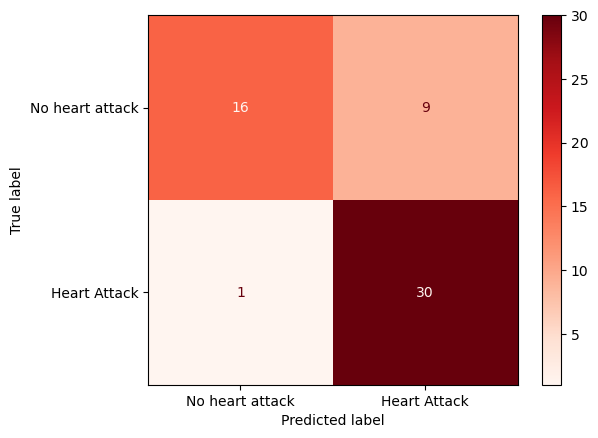

In [53]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Reds')
plt.show()

# Model Saving

In [47]:

if not os.path.exists('model'):
    os.makedirs('model')

In [48]:
for i, model in enumerate(pipelines_ht):
    cv_ht = GridSearchCV(model, param_grid=param_grids[i])
    cv_ht.fit(X_train, y_train)
    MODEL_PATH = os.path.join(os.getcwd(), 'model', '{}.pkl'.format(model_name_ht[i]))
    with open(MODEL_PATH, 'wb') as file:
        pickle.dump(cv_ht.best_estimator_, file)

# Testing our model with new data

In [49]:
with open(MODEL_PATH, 'rb') as file:
    loaded_model = pickle.load(file)

In [50]:
test_data = pd.read_csv('datasets\heart_newtest.csv')
X_test = test_data.drop('True_output', axis=1)
y_test = test_data['True_output']

In [51]:
y_pred = loaded_model.predict(X_test)

In [52]:
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.9
